In [1]:
import sys
sys.path.append('..')
import code_package.tools_func as tool
import code_package.model_package as mcr2_model
import importlib
import yaml
import code_package.mcr2_trainer as mcr2_trainer
import code_package.run_code_timer as run_code_timer
import torch
import os
import numpy as np
importlib.reload(mcr2_model)
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# 启用 LaTeX 风格文本渲染
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['font.family'] = 'serif'
f_s = 14
matplotlib.rcParams['axes.labelsize'] = f_s
matplotlib.rcParams['axes.titlesize'] = f_s
matplotlib.rcParams['xtick.labelsize'] = f_s
matplotlib.rcParams['ytick.labelsize'] = f_s
matplotlib.rcParams['legend.fontsize'] = f_s
from matplotlib import pyplot as plt

In [3]:
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X', 'd'] + ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X', 'd'] +['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X', 'd']

# Define 10 high-contrast, bright colors
colors = [
    '#4F83FF',  
    '#FF9933',  
    '#99CC33',  
    '#FF9999',  
    '#6666CC',  
    '#FFCC00',  
    '#99ccff',  
    '#CC99CC',  
    '#3ea03a',  
    '#CC0033'
]

In [4]:
# 读取数据 和 model
data_folder = 'dataloaders'
data_path = os.path.join(data_folder,'3','cmapss_004.pt')
data_loader, data_set = torch.load(data_path,map_location=DEVICE)

C:\Users\linan\AppData\Local\Temp\ipykernel_35868\2002630183.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_loader, data_set = torch.load(data_path,map_location=DE

In [5]:
# 准备model
base_dir = './res_lrd'
kl_weights = 0.001
model_path = os.path.join(base_dir, 'kl_'+str(kl_weights), 'models')
best_start = '2' 
mcr2_model_path = os.path.join(model_path, best_start, 'best_model.pth')
# model
params_path = os.path.join('model_params','cmapss_lrd.yaml')
cmapss_lrd_params = yaml.load(open(params_path, 'r'), Loader=yaml.FullLoader)
encoder_params = cmapss_lrd_params['encoder_params']
decoder_params = cmapss_lrd_params['decoder_params']
decoder_params['decoder_depth'] = 2
decoder_params['decoder_width'] = [200,50]
decoder_params['recons_activation'] = 'None'
encoder_params['encoder_activation'] = 'leaky_relu'
decoder_params['decoder_activation'] = 'leaky_relu'
encoder_params['cov_activation'] = 'sigmoid'
latent_dim = 3
class_dim = latent_dim
encoder_params['class_dim'] = class_dim
encoder_params['latent_dim'] = latent_dim
decoder_params['class_dim'] = class_dim
decoder_params['latent_dim'] = latent_dim
decoder_params['drop_rate'] = 0.1
mcr2 =  mcr2_model.MCR2(encoder_params, decoder_params, is_ts=0, kl_weights=kl_weights)
mcr2.load_state_dict(torch.load(mcr2_model_path, map_location=DEVICE)[0])
mcr2.to(DEVICE)
mcr2.eval()


C:\Users\linan\AppData\Local\Temp\ipykernel_35868\4044932247.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mcr2.load_state_dict(torch.load(mcr2_model_path, map_locati

MCR2(
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (encoder): MCR2Encoder(
    (encoder): Sequential(
      (layer0): Linear(in_features=17, out_features=50, bias=True)
      (dropout0): Dropout(p=0.0, inplace=False)
      (relu0): LeakyReLU(negative_slope=0.01)
      (layer1): Linear(in_features=50, out_features=50, bias=True)
      (dropout1): Dropout(p=0.0, inplace=False)
      (relu1): LeakyReLU(negative_slope=0.01)
      (layer2): Linear(in_features=50, out_features=200, bias=True)
      (dropout2): Dropout(p=0.0, inplace=False)
      (relu2): LeakyReLU(negative_slope=0.01)
    )
    (direct): Sequential(
      (direct): Linear(in_features=200, out_features=3, bias=True)
    )
    (cov_vec_layer): Sequential(
      (cl): Linear(in_features=200, out_features=1, bias=True)
      (c_ac): Sigmoid()
    )
    (mu_layer): Sequential(
      (ml): Linear(in_features=200, out_features=1, bias=True)
      (m_ac): Sigmoid()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(


In [6]:
# 准备model
import yaml
params_path = os.path.join('model_params','cmapss_ae.yaml')
cmapss_lrd_params = yaml.load(open(params_path, 'r'), Loader=yaml.FullLoader)
configs = yaml.load(open('configs/cmapss_cvae_config.yaml', 'r'), Loader=yaml.FullLoader)

encoder_params = cmapss_lrd_params['encoder_params']
decoder_params = cmapss_lrd_params['decoder_params']
encoder_params['class_dim'] = class_dim
encoder_params['latent_dim'] = latent_dim
decoder_params['class_dim'] = class_dim
decoder_params['latent_dim'] = latent_dim
decoder_params['recons_activation'] = None
base_dir = './res_cvae' #0621
kl_weights = 0.001
loss_dict = torch.load(os.path.join(base_dir, 'kl_'+str(kl_weights), 'val_loss_ls.pt'))
print(min(loss_dict, key=loss_dict.get))
model_path = os.path.join(base_dir, 'kl_'+str(kl_weights), 'models')
best_start =  str(min(loss_dict, key=loss_dict.get))
cvae_model_path = os.path.join(model_path, best_start, 'best_model.pth')
encoder_params['cov_activation'] = 'None'
encoder_params['mu_activation'] = 'None'
cvae =  mcr2_model.CVAE(encoder_params, decoder_params, is_ts=0, kl_weights=kl_weights)
cvae.load_state_dict(torch.load(cvae_model_path, map_location=DEVICE)[0])
cvae.eval()
cvae.to(DEVICE)

2


C:\Users\linan\AppData\Local\Temp\ipykernel_35868\3849721381.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_dict = torch.load(os.path.join(base_dir, 'kl_'+str(kl_

CVAE(
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (encoder): CVAEEncoder(
    (encoder): Sequential(
      (layer0): Linear(in_features=17, out_features=50, bias=True)
      (dropout0): Dropout(p=0.0, inplace=False)
      (relu0): LeakyReLU(negative_slope=0.01)
      (layer1): Linear(in_features=50, out_features=50, bias=True)
      (dropout1): Dropout(p=0.0, inplace=False)
      (relu1): LeakyReLU(negative_slope=0.01)
      (layer2): Linear(in_features=50, out_features=200, bias=True)
      (dropout2): Dropout(p=0.0, inplace=False)
      (relu2): LeakyReLU(negative_slope=0.01)
    )
    (cov_vec_layer): Sequential(
      (cl): Linear(in_features=200, out_features=3, bias=True)
    )
    (mu_layer): Sequential(
      (ml): Linear(in_features=200, out_features=3, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (layer0): Linear(in_features=6, out_features=200, bias=True)
      (dropout0): Dropout(p=0.1, inplace=False)
      (acti0): LeakyReLU(negativ

In [7]:
set_name = 'train'
with torch.no_grad():
    mcr2_res = mcr2(data_set[set_name][0], data_set[set_name][1], data_set[set_name][2])
    mcr2.lambdas = 1e-20
    mcr2_loss_res = mcr2.loss_function(mcr2_res, data_set[set_name][0])
    
    cvae_res = cvae(data_set[set_name][0], data_set[set_name][1], data_set[set_name][2])
    cvae_loss_res = cvae.loss_function(cvae_res, data_set[set_name][0])
    

d:\linan\code_simulated_data\LRD_project\code_cmapss\..\code_package\model_package.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob = torch.reshape(torch.tensor(sample_weights).float().to(mu.device), (-1,1))*prob


## MCR2 res

In [8]:
type_0 = []
type_1 = []
for i in range(1, 250):
    idx1 = data_set[set_name][4][:,0] == i
    idx2 = mcr2_res['z'][idx1][:,1].argsort()
    label = mcr2_res['z'][idx1][idx2][-1,2]>0
    if label:
        type_1.append(i)
    else:
        type_0.append(i)

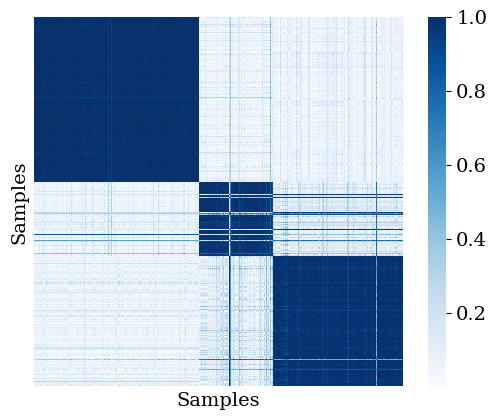

In [9]:
import seaborn as sns
res = mcr2_res
pred_label = np.argmax(res['prob'].cpu(), axis=1)
pred_label[pred_label == 0] = 3
pred_label[pred_label == 1] = 0
pred_label[pred_label == 3] = 1
z = res['z'][pred_label.cpu().numpy().argsort()]
z_norm = (z/torch.norm(z, dim=1, keepdim=True)).cpu().numpy()
heat_res = abs((z_norm @ z_norm.T)[1::50,1::50])
sns.heatmap(heat_res, cmap='Blues', xticklabels=False, yticklabels=False, square=True)
#plt.colorbar(label='Working cycle')
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Samples', fontsize=14)
#plt.title('Latent Space Similarity Heatmap')

fig_path = os.path.join('FIGS', 'lrd_similarity.png')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)

In [10]:
clu_idx = [1,0,2]

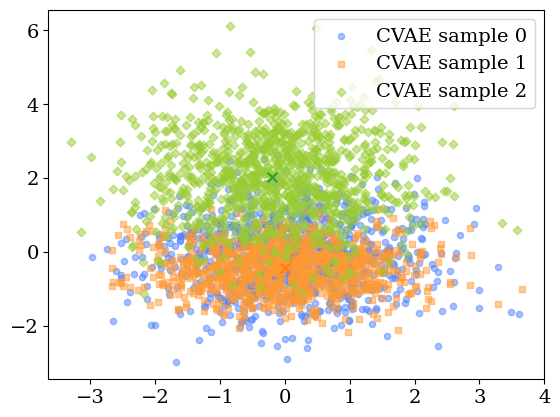

In [19]:
from sklearn.mixture import GaussianMixture
cvaegmm = GaussianMixture(n_components=latent_dim, covariance_type='diag', random_state=0)
cvaegmm.fit(cvae_res['z'].cpu().numpy())
cvae_label_test = cvaegmm.predict(cvae_res['z'].cpu().numpy())
import numpy as np
for i in range(latent_dim):
    mu, cov = torch.tensor(cvaegmm.means_[i]), torch.tensor(np.diag(cvaegmm.covariances_[i]))
    n_sample = 1000
    samples = torch.distributions.MultivariateNormal(mu, cov).sample((n_sample,)).float()
    plt.scatter(samples[:, 0], samples[:, 1], s=20, alpha=0.5, label=f'CVAE sample {i}',color=colors[i], marker=markers[i])
    plt.scatter(cvaegmm.means_[i, 0], cvaegmm.means_[i, 1], s=50, alpha=1, marker='x')
plt.legend()  

cvae_clu_idx = [0,1,2] 

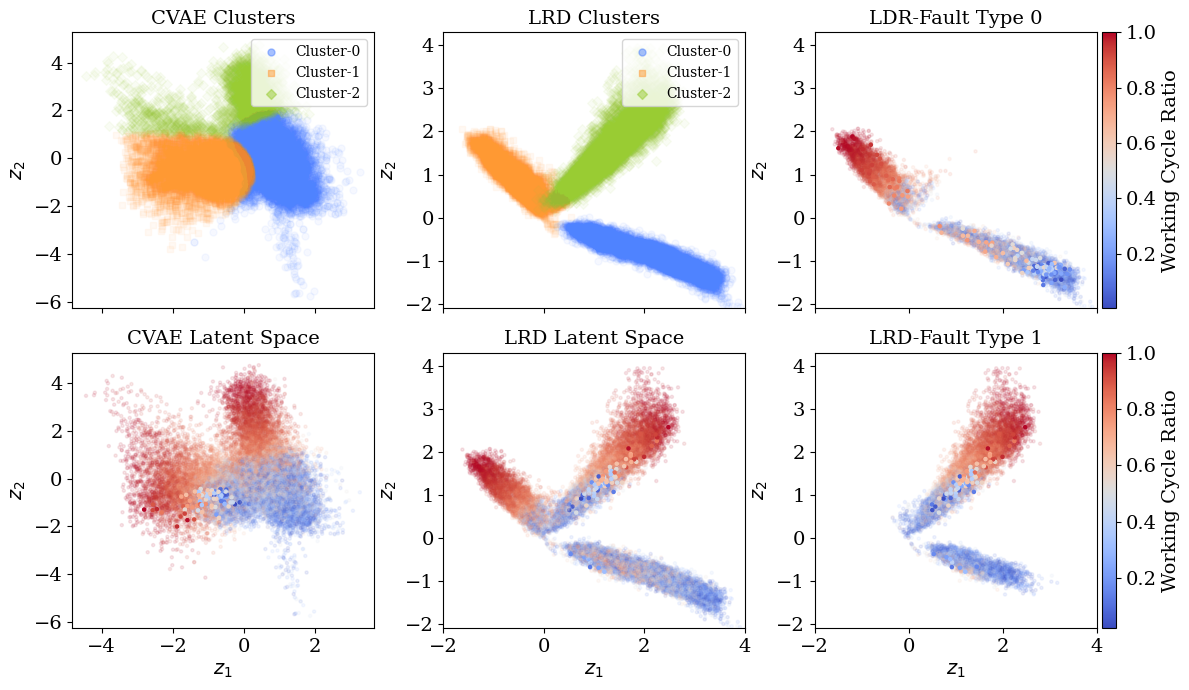

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_idx = [2,1]

# 对比分类情况
fig, axes = plt.subplots(2, 3, figsize=(12, 7),sharex='col')
# MCR2 分类结果
for i in range(3):
    pred_label = np.argmax(mcr2_res['prob'].cpu(), axis=1)
    idx = (pred_label == clu_idx[i])
    axes[0,1].scatter(mcr2_res['z'][idx, 2][:1].cpu().numpy(), mcr2_res['z'][idx, 1][:1].cpu().numpy(), color=colors[i], marker=markers[i], s=25, label='Cluster-'+str(i), alpha=0.5)
    axes[0,1].scatter(mcr2_res['z'][idx, 2].cpu().numpy(), mcr2_res['z'][idx, 1].cpu().numpy(), color=colors[i], marker=markers[i], s=25, alpha=0.05)

axes[0,1].set_title('LRD Clusters')
#axes[0,1].set_xlabel(r'$z_1$')
axes[0,1].set_ylabel(r'$z_2$')
axes[0,1].legend(loc='upper right', fontsize=10)
axes[0,1].set_xlim([-2,4])
axes[0,1].set_ylim([-2.1,4.3])

for i in range(3):
    cvae_pred_label = cvaegmm.predict(cvae_res['z'].cpu().numpy())
    idx = (cvae_pred_label == cvae_clu_idx[i])
    axes[0,0].scatter(cvae_res['z'][idx, 2][:1].cpu().numpy(), cvae_res['z'][idx, 1][:1].cpu().numpy(), color=colors[i], marker=markers[i], s=25, label='Cluster-'+str(i), alpha=0.5)
    axes[0,0].scatter(cvae_res['z'][idx, 2].cpu().numpy(), cvae_res['z'][idx, 1].cpu().numpy(), color=colors[i], marker=markers[i], s=25, alpha=0.05)
axes[0,0].legend(loc='upper right', fontsize=10)
axes[0,0].set_title('CVAE Clusters')
#axes[0,0].set_xlabel(r'$z_1$')
axes[0,0].set_ylabel(r'$z_2$')   

m, n = 1,1
for i in type_1+type_0: 
    idx = data_set[set_name][4].cpu().numpy()[:,0]  == i
    plot_idx = [2,1]
    if i == type_1[-1]:
        sc0 = axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1]/(np.max(data_set[set_name][4].cpu().numpy()[idx,1])), cmap='coolwarm', s=5)
    else:
        axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1], alpha=0.1, cmap='coolwarm', s=5)
axes[1,1].set_title('LRD Latent Space')
axes[1,1].set_xlabel(r'$z_1$')
axes[1,1].set_ylabel(r'$z_2$')
axes[1,1].set_xlim([-2,4])
axes[1,1].set_ylim([-2.1,4.3])

res =  cvae_res
m, n = 1,0
for i in type_1+type_0:
    idx = data_set[set_name][4].cpu().numpy()[:,0]  == i
    plot_idx = [2,1]
    if i == type_1[-1]:
        sc1 = axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1]/(np.max(data_set[set_name][4].cpu().numpy()[idx,1])), cmap='coolwarm', s=5)
    else:
        axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1], alpha=0.1, cmap='coolwarm', s=5)
axes[1,0].set_title('CVAE Latent Space')
axes[1,0].set_xlabel(r'$z_1$')
axes[1,0].set_ylabel(r'$z_2$')


m = 0
n = 2
res = mcr2_res
for i in type_0:
    idx = data_set[set_name][4].cpu().numpy()[:,0]  == i
    plot_idx = [2,1]
    if i == type_0[-1]:
        sc3 = axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1]/(np.max(data_set[set_name][4].cpu().numpy()[idx,1])), cmap='coolwarm', s=5)
    else:
        axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1], alpha=0.1, cmap='coolwarm', s=5)
divider = make_axes_locatable(axes[m,n])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc3, cax=cax, label='Working Cycle Ratio')
axes[m,n].set_title('LDR-Fault Type 0')
#axes[m,n].set_xlabel(r'$z_1$')
axes[m,n].set_ylabel(r'$z_2$')
axes[m,n].set_xlim([-2,4])
axes[m,n].set_ylim([-2.1,4.3])
m = 1
n = 2
res = mcr2_res
for i in type_1:
    idx = data_set[set_name][4].cpu().numpy()[:,0]  == i
    plot_idx = [2,1]
    if i == type_1[-1]:
        sc4 = axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1]/(np.max(data_set[set_name][4].cpu().numpy()[idx,1])), cmap='coolwarm', s=5)
    else:
        axes[m,n].scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set[set_name][4].cpu().numpy()[idx,1], alpha=0.1, cmap='coolwarm', s=5)
divider = make_axes_locatable(axes[m,n])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc4, cax=cax, label='Working Cycle Ratio')
axes[m,n].set_title('LRD-Fault Type 1')
axes[m,n].set_xlabel(r'$z_1$')
axes[m,n].set_ylabel(r'$z_2$')
axes[m,n].set_xlim([-2,4])
axes[m,n].set_ylim([-2.1,4.3])
plt.tight_layout(w_pad=0.1)
fig_path = os.path.join('FIGS', 'lrd_cvae.png')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)

plt.show()

In [22]:
def decode_sensor(mcr2, mu, cov, con, n_sample=1000):
    """
    :param mcr2:
    :param mu: latent space
    :param cov: covariance matrix
    :param n_sample: number of samples
    :return:
    """
    z = torch.distributions.MultivariateNormal(mu, cov).sample((n_sample,)).float()
    z = z.to(DEVICE)
    con = torch.ones((n_sample, 1)).to(DEVICE) * con
    con = con.float()
    decoder_input = torch.cat((z, con), dim=1)
    with torch.no_grad():
        output = mcr2.decoder(decoder_input)
    return output, np.cov(output.cpu().numpy().T), np.corrcoef(output.cpu().numpy().T), z

In [23]:
prior_dict = {}
prior_dict_o = {}
posterior_dict = {}
posterior_dict_o = {}
eigs_val_ls = []
for i in range(latent_dim):
    mu = torch.tensor(mcr2.mu_prior[i])
    eigenvalues, eigenvectors = torch.linalg.eigh(mcr2.Q_prior[i])
    # 获取最大特征值对应的特征向量
    max_eigenvector = eigenvectors[:, -1]
    print(eigenvalues/eigenvalues.sum())
    eigs_val_ls.append((eigenvalues/eigenvalues.sum()).cpu().numpy())
    # 还原矩阵
    reduced_matrix = torch.outer(max_eigenvector, max_eigenvector) + torch.eye(latent_dim).to(DEVICE) * 1e-7
    cov = torch.tensor(reduced_matrix)
    con = data_set['test'][1][0]
    sensor_recons, covariance, corrcoef, z = decode_sensor(mcr2, mu, cov, con, n_sample=1000)
    prior_dict[i] = {
        'mu': mu,
        'cov': cov,
        'con': con,
        'z': z,
        'sensor_recons': sensor_recons,
        'covariance': covariance,
        'corrcoef': corrcoef
    }
    
    sensor_recons, covariance, corrcoef, z = decode_sensor(mcr2, mu, mcr2.Q_prior[i], con, n_sample=1000)
    prior_dict_o[i] = {
        'mu': mu,
        'cov': cov,
        'con': con,
        'z': z,
        'sensor_recons': sensor_recons,
        'covariance': covariance,
        'corrcoef': corrcoef
    }
    
    reduced_matrix = torch.outer(max_eigenvector, max_eigenvector) + torch.eye(latent_dim).to(DEVICE) * 1e-7
    cov = torch.tensor(reduced_matrix)/100
    idx = prior_dict[i]['z'][:,0].argsort()
    mu = prior_dict[i]['z'][idx[500]]
    #cov = prior_dict[i]['cov']/100 #prior_dict[i]['z'][100]/torch.norm(prior_dict[i]['z'][100], p='fro')/30
    #cov = torch.outer(cov, cov) + torch.eye(latent_dim).to(DEVICE) * 1e-6
    sensor_recons, covariance, corrcoef, z = decode_sensor(mcr2, mu, cov, con, n_sample=1000)
    
    posterior_dict[i] = {
        'mu': mu,
        'cov': cov, 
        'con': con,
        'z': z,
        'sensor_recons': sensor_recons,
        'covariance': covariance,
        'corrcoef': corrcoef
    }

tensor([0.0067, 0.0379, 0.9554], device='cuda:0')
tensor([0.0119, 0.0306, 0.9574], device='cuda:0')
tensor([0.0316, 0.0684, 0.9001], device='cuda:0')


C:\Users\linan\AppData\Local\Temp\ipykernel_24216\3453738121.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(mcr2.mu_prior[i])
C:\Users\linan\AppData\Local\Temp\ipykernel_24216\3453738121.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov = torch.tensor(reduced_matrix)
C:\Users\linan\AppData\Local\Temp\ipykernel_24216\3453738121.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov = torch.tensor(reduced_matrix)/100


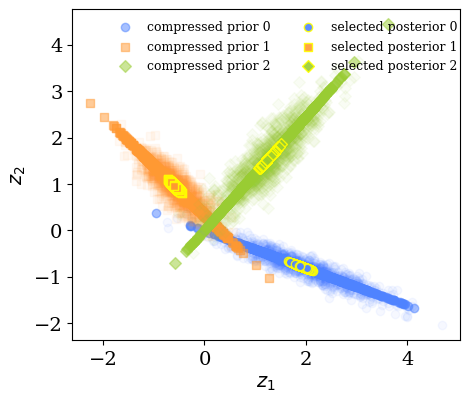

In [24]:
plt.figure(figsize=(5, 4.3))

handles = []
labels = ['compressed prior 0',
          'selected posterior 0',
           'compressed prior 1',
           'selected posterior 1', 
            'compressed prior 2',
            'selected posterior 2']
for i in range(3):
    k = clu_idx[i]
    plt.scatter(prior_dict_o[k]['z'][:,2].cpu().numpy().reshape(-1),
                prior_dict_o[k]['z'][:,1].cpu().numpy().reshape(-1), 
                alpha=0.05, color=colors[i], marker=markers[i])
    handles.append(plt.scatter(prior_dict[k]['z'][:,2].cpu().numpy().reshape(-1),
                prior_dict[k]['z'][:, 1].cpu().numpy().reshape(-1), 
                alpha=0.5, color=colors[i], marker=markers[i]))
    handles.append(plt.scatter(posterior_dict[k]['z'][:,2].cpu().numpy().reshape(-1),
                posterior_dict[k]['z'][:, 1].cpu().numpy().reshape(-1), 
                alpha=0.9, color=colors[i], edgecolors='yellow', marker=markers[i]))
order = [0, 2, 4, 1, 3, 5]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.figlegend(ordered_handles, ordered_labels, ncol=2, frameon=False, fontsize=9, loc='upper center', bbox_to_anchor=(0.55, 0.88))
#plt.show()
#plt.legend(frameon=False, ncols=2, loc='upper right',fontsize=10)
#plt.tight_layout()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
fig_path = os.path.join('FIGS', 'lrd_prior.png')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)

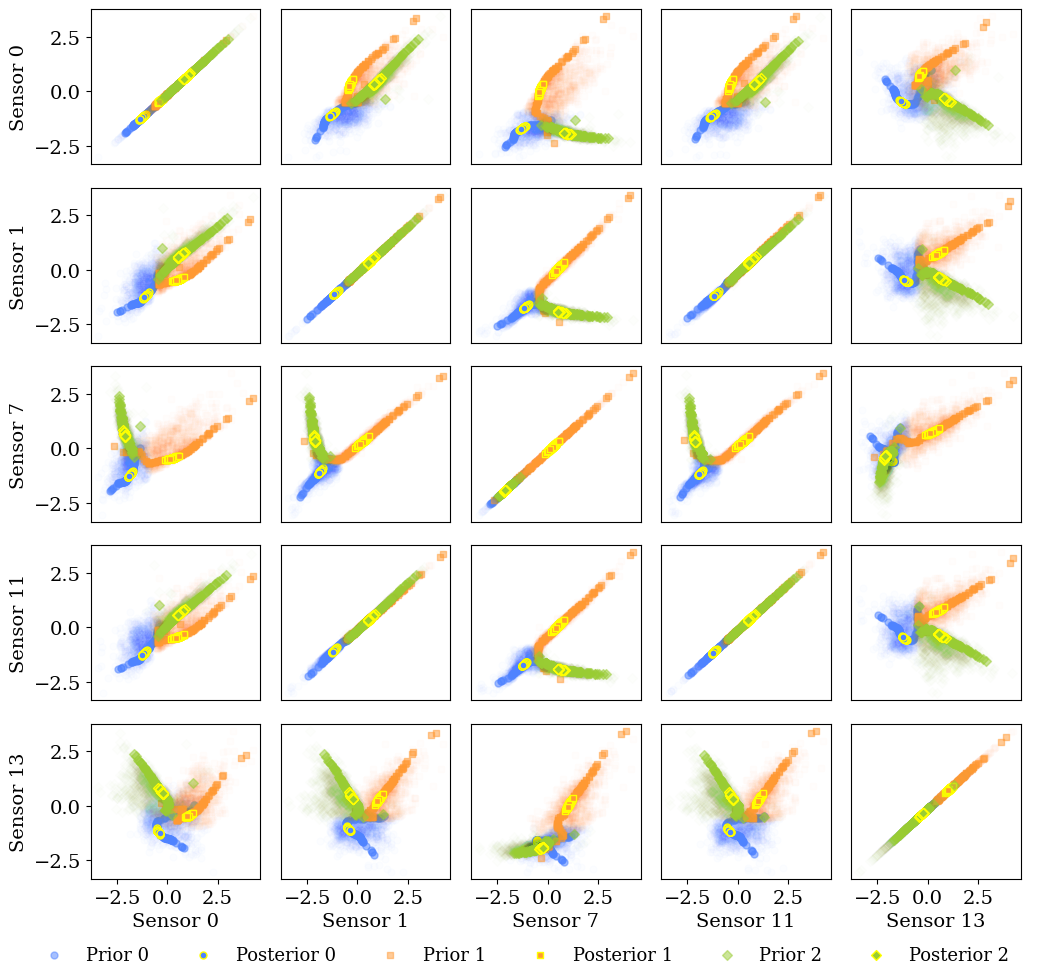

In [118]:
plt.figure(figsize=(10, 10))
sensor_idx = [0, 1, 7, 11, 13]
m = 0
handles = []
labels = []
for i in range(len(sensor_idx)):
    for j in range(len(sensor_idx)):
        m += 1
        for k in range(3):
            plt.subplot(5, 5, m)
            h1 = plt.scatter(
                prior_dict_o[clu_idx[k]]['sensor_recons'][:, sensor_idx[i]].cpu().numpy().reshape(-1),
                prior_dict_o[clu_idx[k]]['sensor_recons'][:, sensor_idx[j]].cpu().numpy().reshape(-1),
                color=colors[k], marker=markers[k], alpha=0.01, s=25, label=f'Prior {k}' if (i == 0 and j == 0) else None
            )
            h2 = plt.scatter(
                prior_dict[clu_idx[k]]['sensor_recons'][::10, sensor_idx[i]].cpu().numpy().reshape(-1),
                prior_dict[clu_idx[k]]['sensor_recons'][::10, sensor_idx[j]].cpu().numpy().reshape(-1),
                color=colors[k], marker=markers[k], s=25, alpha=0.5, label=f'Compact Prior {k}' if (i == 0 and j == 0) else None
            )
            h3 = plt.scatter(
                posterior_dict[clu_idx[k]]['sensor_recons'][::10, sensor_idx[i]].cpu().numpy().reshape(-1),
                posterior_dict[clu_idx[k]]['sensor_recons'][::10, sensor_idx[j]].cpu().numpy().reshape(-1),
                color=colors[k], marker=markers[k], s=25, edgecolors='yellow', alpha=1, label=f'Posterior {k}' if (i == 0 and j == 0) else None
            )
            if i == 0 and j == 0:
                handles.extend([h2, h3])
                labels.extend([f'Prior {k}', f'Posterior {k}'])
            if j == 0:
                plt.ylabel('Sensor ' + str(sensor_idx[i]))
            else:
                plt.yticks([])
            if i == len(sensor_idx) - 1:
                plt.xlabel('Sensor ' + str(sensor_idx[j]))
            else:
                plt.xticks([])

plt.subplots_adjust(wspace=0.12, hspace=0.15, left=0.05, right=0.98, top=0.97, bottom=0.1)
plt.figlegend(handles, labels, loc='lower center', ncol=6, frameon=False, fontsize=13)
fig_path = os.path.join('FIGs','0624', 'lrd_samples.png')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()
plt.show()

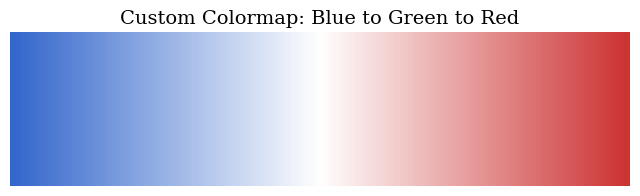

In [54]:
# 定义三个颜色：蓝色、绿色、红色
from matplotlib.colors import LinearSegmentedColormap

colors_c = ['#3366CC', '#FFFFFF', '#CC3333']

# 创建一个线性渐变的 colormap
custom_colormap_rb = LinearSegmentedColormap.from_list('BlueGreenRed', colors_c)

# 可视化 colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(8, 2))
plt.imshow(gradient, aspect='auto', cmap=custom_colormap_rb)
plt.axis('off')
plt.title("Custom Colormap: Blue to Green to Red")
plt.show()

/tmp/ipykernel_1263685/1609941638.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


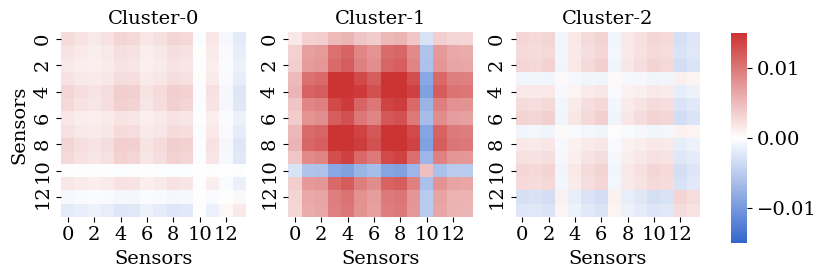

In [125]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, latent_dim, figsize=(8, 3))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
vmax = 1.5e-2
vmin = -vmax
for i in range(latent_dim):
    ax = axes[i]
    sns.heatmap(
        posterior_dict[clu_idx[i]]['covariance'],
        cmap=custom_colormap_rb,
        cbar=(i == latent_dim - 1),
        cbar_ax=cbar_ax if i == latent_dim - 1 else None,
        annot=False,
        center=0,
        vmax=vmax,
        vmin=vmin,
        ax=ax,
        square=True,
    )
    ax.set_title('Cluster-'+str(i))
    if i == 0:
        ax.set_ylabel('Sensors')
    ax.set_xlabel('Sensors')
    #ax.set_ylabel('Sensors')
#fig.suptitle('Posterior sensor reconstruction covariance', y=0.90)
plt.tight_layout(rect=[0, 0, 0.9, 1])
fig_path = os.path.join('FIGs','0624', 'lrd_heat.png')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

In [92]:
idx

tensor(5056, device='cuda:1')

In [120]:
cvae_posterior_dict = {}
con = data_set['test'][1][100]
for i in range(latent_dim):
    idx = cvae_res['mu'][cvae_label_test==cvae_clu_idx[i]][:,0].argsort()[int(cvae_res['mu'][cvae_label_test==cvae_clu_idx[i]].shape[0]/2)]
    mu = cvae_res['mu'][cvae_label_test==cvae_clu_idx[i]][idx]
    cov = torch.diag(torch.exp(0.5*cvae_res['cov_vec'][cvae_label_test==cvae_clu_idx[i]][idx]))
    sensor_recons, covariance, corrcoef, z = decode_sensor(cvae, mu, cov, con, n_sample=1000)
    cvae_posterior_dict[i] = {
        'mu': mu,
        'cov': cov,
        'con': con,
        'z': z,
        'sensor_recons': sensor_recons,
        'covariance': covariance,
        'corrcoef': corrcoef
    }
    
cvae_prior_dict = {}
con = data_set['test'][1][100]
for i in range(latent_dim):
    mu = torch.tensor(cvaegmm.means_[cvae_clu_idx[i]])
    cov = torch.diag(torch.tensor(cvaegmm.covariances_[cvae_clu_idx[i]]))
    sensor_recons, covariance, corrcoef, z = decode_sensor(cvae, mu, cov, con, n_sample=1000)
    cvae_prior_dict[i] = {
        'mu': mu,
        'cov': cov,
        'con': con,
        'z': z,
        'sensor_recons': sensor_recons,
        'covariance': covariance,
        'corrcoef': corrcoef
    }

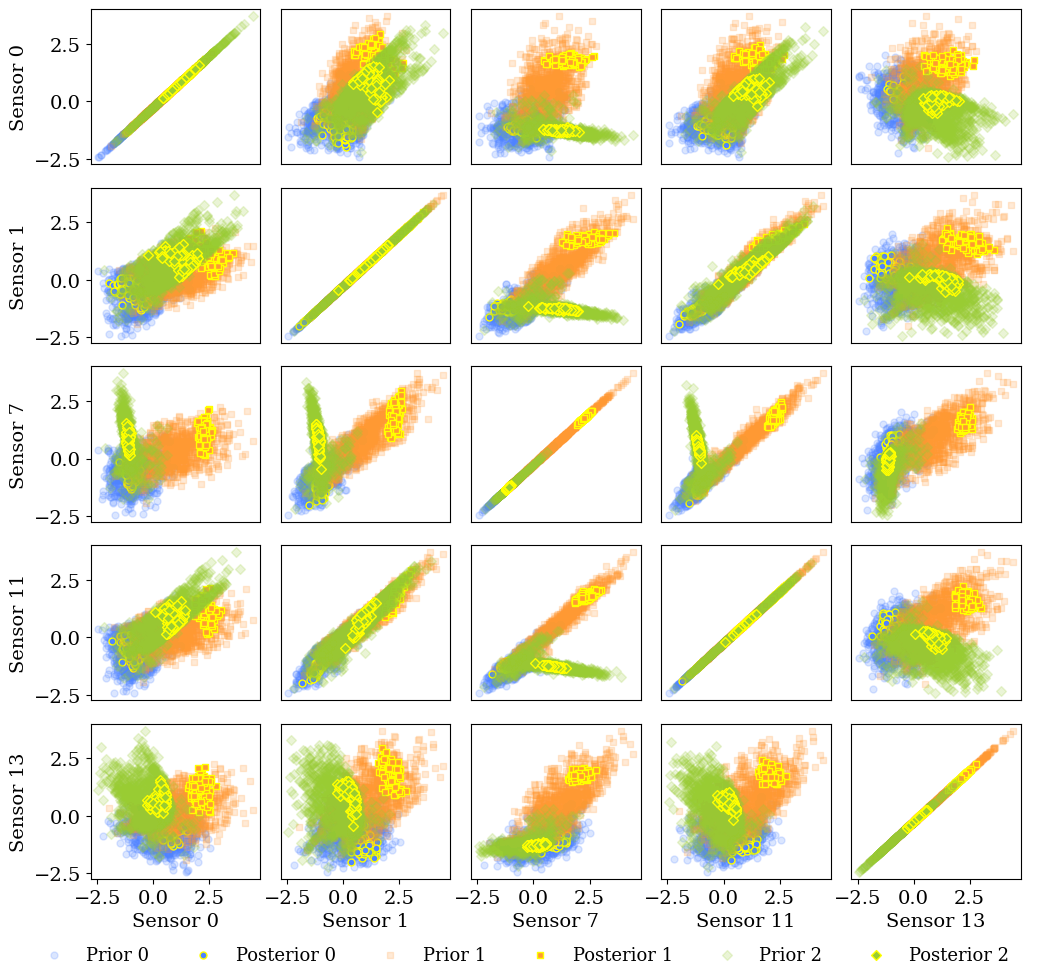

In [122]:
plt.figure(figsize=(10, 10))
m = 0
handles = []
labels = []
for i in range(len(sensor_idx)):
    for j in range(len(sensor_idx)):
        m += 1
        for k in range(3):
            plt.subplot(5, 5, m)
            h1 = plt.scatter(
                cvae_prior_dict[k]['sensor_recons'][:, sensor_idx[i]].cpu().numpy().reshape(-1),
                cvae_prior_dict[k]['sensor_recons'][:, sensor_idx[j]].cpu().numpy().reshape(-1),
                color=colors[k], marker=markers[k], alpha=0.2, s=25, label=f'Prior {k}' if (i == 0 and j == 0) else None
            )
            h2 = plt.scatter(
                cvae_posterior_dict[k]['sensor_recons'][::10, sensor_idx[i]].cpu().numpy().reshape(-1),
                cvae_posterior_dict[k]['sensor_recons'][::10, sensor_idx[j]].cpu().numpy().reshape(-1),
                color=colors[k],  marker=markers[k], s=25, edgecolors='yellow', alpha=1, label=f'Posterior {k}' if (i == 0 and j == 0) else None
            )
            if i == 0 and j == 0:
                handles.extend([h1, h2])
                labels.extend([f'Prior {k}', f'Posterior {k}'])
            if j == 0:
                plt.ylabel('Sensor ' + str(sensor_idx[i]))
            else:
                plt.yticks([])
            if i == len(sensor_idx) - 1:
                plt.xlabel('Sensor ' + str(sensor_idx[j]))
            else:
                plt.xticks([])

plt.subplots_adjust(wspace=0.12, hspace=0.15, left=0.05, right=0.98, top=0.97, bottom=0.1)
plt.figlegend(handles, labels, loc='lower center', ncol=6, frameon=False, fontsize=13)
#plt.suptitle('Posterior sensor reconstruction', y = 0.94)
fig_path = os.path.join('FIGs','0624', 'cvae_samples.png')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_1263685/4087319175.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


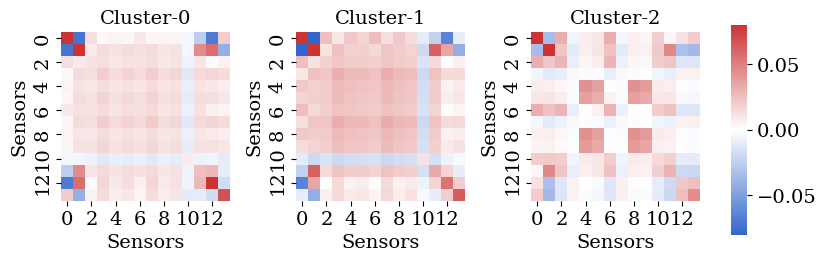

In [124]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, latent_dim, figsize=(8, 3))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
vmax = 0.08
vmin = -vmax
for i in range(latent_dim):
    ax = axes[i]
    sns.heatmap(
        cvae_posterior_dict[i]['covariance'],
        cmap=custom_colormap_rb,
        cbar=(i == latent_dim - 1),
        cbar_ax=cbar_ax if i == latent_dim - 1 else None,
        annot=False,
        center=0,
        vmax=vmax,
        vmin=vmin,
        ax=ax,
        square=True,
    )
    ax.set_title('Cluster-'+str(i))
    ax.set_xlabel('Sensors')
    ax.set_ylabel('Sensors')
#fig.suptitle('Posterior sensor reconstruction covariance', y=0.90)
plt.tight_layout(rect=[0, 0, 0.9, 1])

#plt.suptitle('Posterior sensor reconstruction', y = 0.94)
fig_path = os.path.join('FIGs','0624', 'cvae_heat.png')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

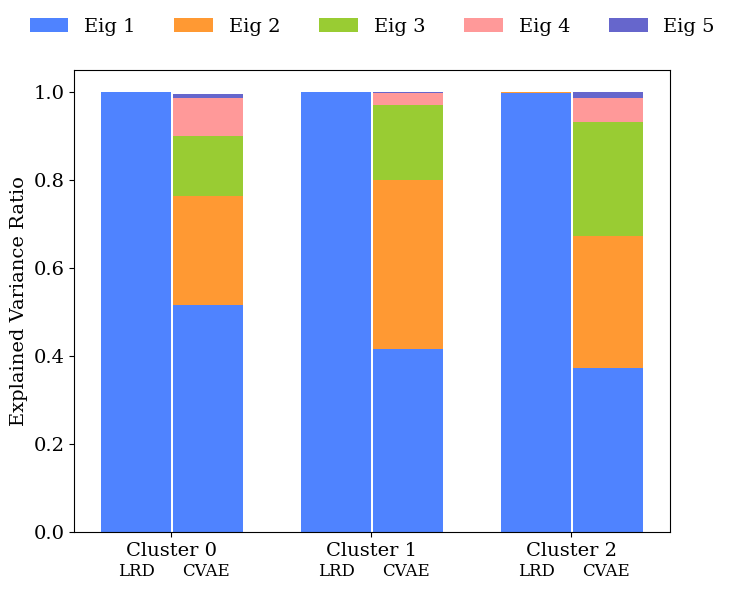

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 稳定版本的特征值提取函数
def get_eig_fractions(posterior_dict):
    eigvals = [np.linalg.eigh(posterior_dict[i]['covariance'])[0] for i in range(3)]  # 使用eigh确保对称、实数
    eigvals = [v[::-1] / np.sum(v) for v in eigvals]  # 从大到小排序并归一化
    eigvals = np.array(eigvals)  # shape: (3, dim)
    return eigvals.T  # shape: (dim, 3)

# 提取前5个特征值占比
eig_mcr2 = get_eig_fractions(posterior_dict)
eig_cvae = get_eig_fractions(cvae_posterior_dict)

categories = np.arange(3)  # LRD-0,1,2 对应位置
bar_width = 0.35

fig, ax = plt.subplots(figsize=(7.5, 6))

# 堆叠绘图函数
def plot_stacked_bars(eigvals, base_pos, label_prefix, colors):
    bottoms = np.zeros_like(categories, dtype=float)
    for i in range(5):
        ax.bar(base_pos, eigvals[i], bar_width, bottom=bottoms,
               label=f'Eig {i+1}' if label_prefix == 'LRD' else None,
               color=colors[i])
        bottoms += eigvals[i]

# 绘制 LRD 和 CVAE
plot_stacked_bars(eig_mcr2, categories - bar_width / 2, 'LRD', colors)
plot_stacked_bars(eig_cvae, categories + bar_width / 2+0.01, 'CVAE', colors)

# 标签与样式
ax.set_ylabel('Explained Variance Ratio')
ax.set_ylim([0, 1.05])
ax.set_xticks(categories)
ax.set_xticklabels([f'Cluster {i}' for i in range(3)])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, frameon=False)
#ax.set_title('Posterior Covariance Eigenvalue Comparison')

# 添加底部标签注解
for i in range(3):
    ax.text(categories[i] - bar_width / 2, -0.1, 'LRD', ha='center', fontsize=12)
    ax.text(categories[i] + bar_width / 2, -0.1, 'CVAE', ha='center', fontsize=12)

plt.tight_layout()
fig_path = os.path.join('FIGs', '0624', 'lrd_cvae_eigs.pdf')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()
